In [1]:
import codecs, json, glob, os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tensorflow as tf
from sklearn.metrics import confusion_matrix, jaccard_score, classification_report, f1_score
import numpy as np
import pandas as pd
from tqdm import tqdm

from generator import label_mapping
from utils.image_processing import read_resize

from utils.plotting import plot_image_label_prediction, plot_uncertainty_heatmaps, \
    plot_uncertainty_statistics, plot_image, plot_label, plot_predictions

VALIDATION_RESULT_DIR = "/home/olle/PycharmProjects/LODE/workspace/feature_segmentation/cv_runs_results"

models = os.listdir(VALIDATION_RESULT_DIR)

configured_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15]


## load json files to evaluate

In [2]:
def read_decode_json(file_path):
    obj_text = codecs.open(file_path, 'r', encoding='utf-8').read()
    
    json_result_file = json.loads(obj_text)
    
    image = np.array(json_result_file["image"])
    prediction = np.array(json_result_file["prediction"])
    
    if len(image.shape) > 3:
        image = image[0, :, :, :]
        
    if len(prediction.shape) > 2:
        prediction = prediction[0, :, :]
    
    json_result_file["image"] = image
    json_result_file["label"] = np.array(json_result_file["label"])
    json_result_file["prediction"] = prediction
    return json_result_file

def read_results(model):
    # set paths
    model_dir = os.path.join(VALIDATION_RESULT_DIR, model)
    json_result_paths = glob.glob(model_dir + f"/*.json")

    result_jsons = {}
    
    for json_file_path in json_result_paths:
        record = json_file_path.split("/")[-1].replace(".json", "")
        
        if "model" in record:
            continue
            
        result_jsons[record] = read_decode_json(json_file_path)
    return result_jsons
        
def plot_results(result_jsons, model):
    records = result_jsons.keys()
    
    model_dir = os.path.join(VALIDATION_RESULT_DIR, model)

    for record in records:
        record_log = result_jsons[record]
        data = [record_log["image"], record_log["label"], record_log["prediction"]]

        # all plotting functions
        plot_image_label_prediction(data, model_dir = model_dir, filename=record, mode="test")
        plot_image(record_log["image"], model_dir = model_dir, filename=record, mode="test")
        plot_label(record_log["label"], model_dir = model_dir, filename=record, mode="test")
        plot_predictions([record_log["prediction"]], model_dir = model_dir, filename=record, mode="test")
        
        
def get_results(result_jsons):
    records = result_jsons.keys()

    f1_record_log = {}
    f1_total_log = {}

    all_labels = []
    all_predictions = []

    for record in records:
        record_log = result_jsons[record]

        labels = record_log["label"].flatten()
        predictions = record_log["prediction"].flatten()

        all_labels.extend(labels.tolist())
        all_predictions.extend(predictions.tolist())

        f1_record_log[record] = f1_score(labels, 
                             predictions, 
                             average = None, 
                             labels = configured_labels, 
                             zero_division=1)

    # calculate for each log
    f1_total_log = f1_score(all_labels, 
                            all_predictions, 
                            average = None, 
                            labels = configured_labels, 
                            zero_division=1)

    # convert to data frames for plotting
    total_f1_pd = pd.DataFrame(f1_total_log).T.replace(1.0, np.NaN)
    record_f1_pd = pd.DataFrame(f1_record_log).T.replace(1.0, np.NaN)
    
    return total_f1_pd, record_f1_pd

In [3]:
columns = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
validation_log = pd.DataFrame(columns=columns)

from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import time

def fill_validation_log(model):
    jsons = read_results(model)
    # plot_results(jsons, model)
    total_r, record_r = get_results(jsons)
    return total_r
    # validation_log = validation_log.append(total_r)

In [5]:
from joblib import Parallel, delayed

results = Parallel(n_jobs=2, verbose=1, backend="multiprocessing")(map(delayed(fill_validation_log), 
                                                                       models))

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 11.3min
[Parallel(n_jobs=2)]: Done  66 out of  66 | elapsed: 16.2min finished


In [7]:
columns = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
validation_log = pd.DataFrame(columns=columns)

for i in range(len(results)):
    validation_log = validation_log.append(pd.DataFrame(results[i]))
    
validation_log["model"] = models

In [22]:
validation_log["sort_feature"] = validation_log[[8, 5]].mean(1)
validation_log = validation_log.sort_values(by="sort_feature", ascending=False)

In [25]:
validation_log.iloc[0:NUM_COMPARE]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,model,sort_feature
0,0.976475,0.655404,0.974969,0.860067,0.969984,0.142272,0.813195,0.700236,0.319848,0.753734,0.847482,0.657648,0.993657,0.984226,897386,0.231060
0,0.976763,0.645393,0.974692,0.859585,0.950237,0.138222,0.812814,0.693073,0.323516,0.740155,0.849168,0.622166,0.993594,0.983853,731621,0.230869
0,0.974965,0.638676,0.974297,0.857034,0.969977,0.145514,0.811126,0.711430,0.307419,0.736632,0.838450,0.686612,0.993362,0.978818,229876,0.226467
0,0.975002,0.646023,0.974802,0.860279,0.968743,0.137112,0.812448,0.702420,0.300066,0.745339,0.842382,0.659267,0.993662,0.977156,699196,0.218589
0,0.976843,0.638199,0.974493,0.860435,0.968346,0.135078,0.810798,0.708123,0.296620,0.737646,0.847407,0.648040,0.993575,0.985542,536581,0.215849
0,0.975240,0.642635,0.974637,0.861536,0.967506,0.150030,0.813691,0.701816,0.279275,0.738144,0.847704,0.674198,0.993474,0.977080,447321,0.214652
0,0.977610,0.652686,0.974477,0.861596,0.960777,0.151304,0.813028,0.704207,0.276058,0.748334,0.850575,0.675049,0.993626,0.985235,458024,0.213681
0,0.975500,0.611759,0.974325,0.861726,0.968855,0.150916,0.812481,0.697834,0.272391,0.730347,0.846101,0.662602,0.993548,0.979057,33961,0.211653
0,0.975742,0.628557,0.974643,0.855691,0.968605,0.147503,0.810839,0.696663,0.275519,0.753018,0.844402,0.664909,0.993637,0.980741,806972,0.211511
0,0.976501,0.650048,0.974697,0.858346,0.969672,0.155952,0.810617,0.702565,0.265872,0.744335,0.846645,0.671599,0.993445,0.980254,174640,0.210912


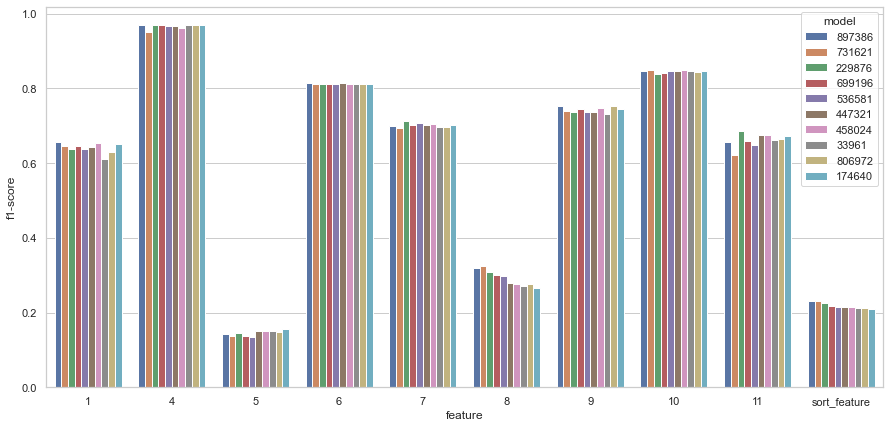

In [28]:
NUM_COMPARE = 10
validation_log_long = pd.melt(validation_log.iloc[0:NUM_COMPARE], id_vars="model")
validation_log_long = validation_log_long.rename(columns={"variable": "feature", "value":"f1-score"})

validation_log_long = validation_log_long[~validation_log_long.feature.isin([0, 3, 2, 12, 13])]
import seaborn as sns
sns.set(rc={'figure.figsize':(15,7)})
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})   

sns.set_theme(style="whitegrid")
ax = sns.barplot(x="feature", y="f1-score", hue="model", data=validation_log_long)
